# Train notebook for focusfinder

Last tutorial on this page should be exactly whats needed

https://docs.fast.ai/tutorial.vision

In [2]:
from fastai.vision.all import *

### test paths

In [2]:
path = Path('../')
labels_path = path/'download/labels/100_norm_imgs.csv'
images_path = path/'download/100_norm_images'

### train paths

In [18]:
path = Path('../')
labels_path = path/'download/labels/norm_labels_4000.csv'
images_path = path/'download/norm_images'

### load labels csv

In [3]:
df = pd.read_csv(labels_path, names=['name','x_p','y_p'], header=0)

In [4]:
df.head()

,name,x_p,y_p
0,0a0c1f65f19859c0.jpg,129.280000,66.133333
1,0a1dae8f71065201.jpg,116.906667,99.318683
2,0a1efc8533c96832.jpg,146.480000,122.148504
3,0a2ca221284ab461.jpg,100.385417,68.654716
4,0a3cf18c620e6a88.jpg,103.168750,99.033851


### define label function
Function is needed that takes the file_name as input and returns the focus point of the corresponing image

In [4]:
import re

def get_file_name(path_name):
    x = re.search(r'\d\w+.jpg', str(path_name))
    return x.group()

def get_focus_point(x):
    file_name = get_file_name(x)
    dfb = next(iter(df[df['name']==file_name].index), ('no match '+file_name))
    return tensor([float(df['x_p'][dfb]), float(df['y_p'][dfb])])

In [7]:
img_files = get_image_files(images_path)
get_focus_point(img_files[40])

tensor([157.1475, 177.0308])

### create datablock and dataloader

In [8]:
imgs = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_focus_point,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=[*aug_transforms(size=(256, 256)),
                Normalize.from_stats(*imagenet_stats)],
    item_tfms=Resize(256),
)

In [9]:
dls = imgs.dataloaders(images_path, bs=32)

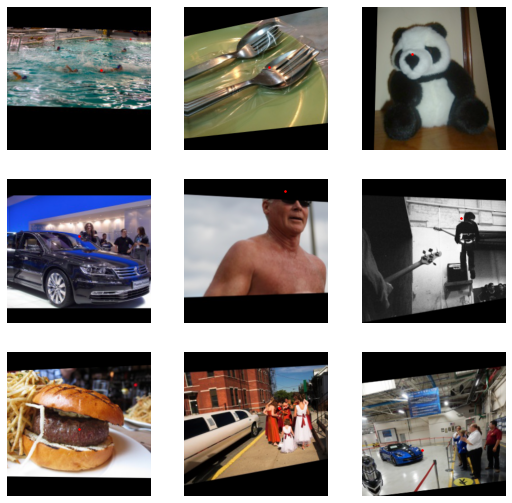

In [10]:
dls.show_batch()

### create model and train

In [11]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))
# try other models

In [12]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.5848931980144698e-06)

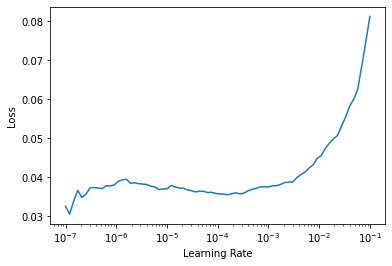

In [44]:
learn.lr_find()

In [13]:
learn.fine_tune(2, 2e-5) # 5e-3
# RETRAIN LATER

epoch,train_loss,valid_loss,time
0,0.529936,0.549038,00:19
1,0.507500,0.476948,00:19


### test model

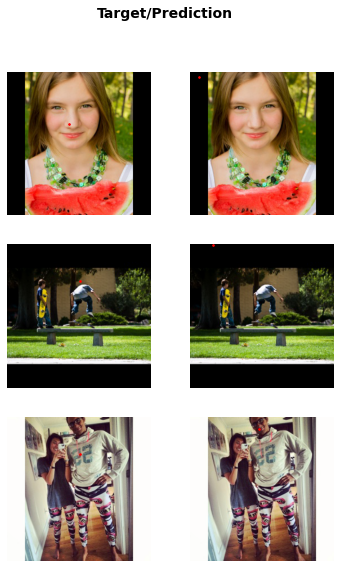

In [14]:
learn.show_results()

In [15]:
preds, y = learn.get_preds()

distances = []
for _p, _y in zip(preds, y):
    d = np.linalg.norm(_p-_y[0])
    distances.append(d)

mean = np.mean(distances)
print('The mean is {:.2f} or {:.2f} px'.format(mean, (mean*256)))
# std_dev = 

- learn_rate: 5e-3
    - The mean is 0.23 or 59.97 px
- learn_rate: 2e-5
    - The mean is 0.63 or 161.16 px

### export model

In [13]:
learn.export('./models/focusfinder_4000_2e-5.pkl')

## load trained model
---

In [5]:
# if model is already trained
model = load_learner('../models/2020115221815-30epochs-0.0002trainrate_model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'models/2020115221815-30epochs-0.0002trainrate_model.pkl'

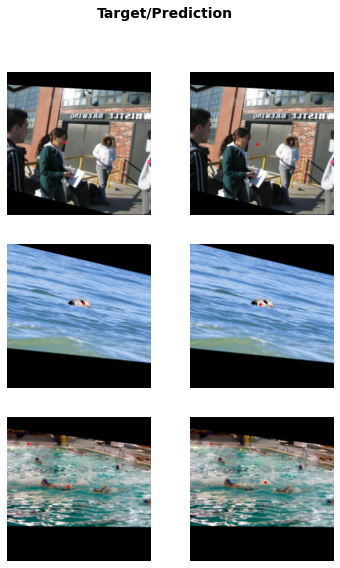

In [28]:
model.show_results(dl=dls)

In [26]:
preds, y = model.get_preds(dl=dls)

distances = []
for _p, _y in zip(preds, y):
    d = np.linalg.norm(_p-_y[0])
    distances.append(d)

mean = np.mean(distances)
print('The mean is {:.2f} or {:.2f} px'.format(mean, (mean*256)))
# std_dev = 